In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

import annotation, image_render, hyspec_io, hyspec_ml

In [2]:
# Paths
hyspec_file_Rrs = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Transect1-15m-AGL/R_rs/manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-ReflectivityConversionFromRadiance.bip.hdr'
# annotation_json = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/label_classes.json'
# annotation_png = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect1_15mAGL_rgb.png'

new_annotation_png = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect1_15mAGL_rgb_refined.png'
new_class_dict_json = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/refined_label_classes.json'

hyspec_file_2 = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Transect2-15m-AGL/R_rs/manual_Pika_L_17-18-radiance-AppendCube-SpatialCrop-ReflectivityConversionFromRadiance.bip.hdr'
annotation_png_2 = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect2_15mAGL_rgb.png'

In [3]:
# Read hyperspectral file
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(hyspec_file_Rrs)

In [4]:
# Limit data to visible range
vis_wl_ind = wl < 750
im = im[:,:,vis_wl_ind]
wl = wl[vis_wl_ind]
(nLines,nSamp,nWl) = im.shape

In [5]:
# Load class dictionary - doesn't work?
class_dict = annotation.read_class_dict(new_class_dict_json)

In [6]:
class_dict

{'Sand': 1,
 'Zostera-marina': 2,
 'Ascophyllum-nodosum': 3,
 'Fucus-vesiculosus': 4}

In [7]:
# Load annotation class mask
annotation_mask = skimage.io.imread(new_annotation_png)

In [8]:
X = im[annotation_mask>0]
X.shape

(349718, 115)

In [9]:
y = annotation_mask[annotation_mask>0]
y.shape

(349718,)

In [10]:
#%% Create pipeline for feature normalization, PCA and classification
clf = make_pipeline(StandardScaler(),PCA(n_components=8), BalancedRandomForestClassifier(n_estimators=20)) 

In [11]:
# Fit classifier
clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(n_estimators=20))])

In [12]:
# Make image vectorizer
im_vz = hyspec_ml.ImageVectorizer(im.shape[0],im.shape[1])

In [13]:
# Apply classifier to whole image
y_pred = clf.predict(im_vz.image3d_to_matrix(im))
y_pred_im = im_vz.vector_to_image2d(y_pred)

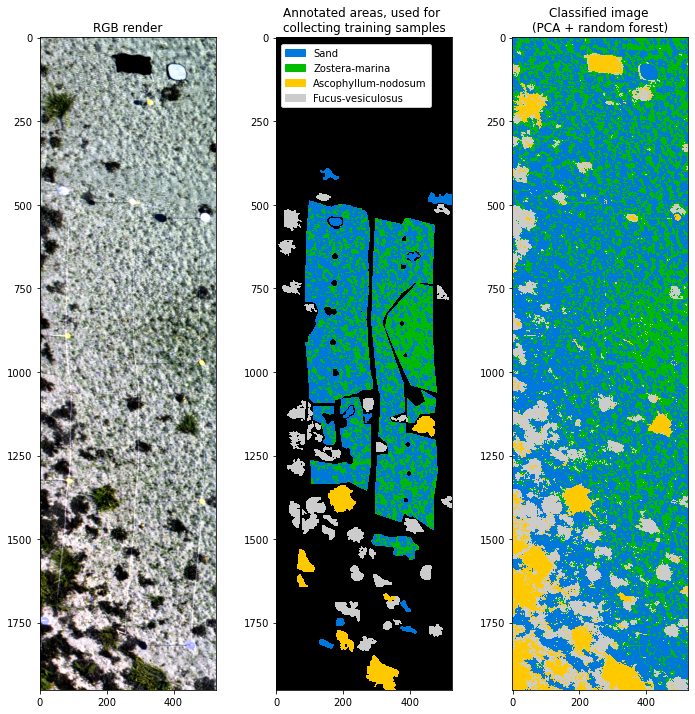

In [14]:
# Visualize result
fig,ax = plt.subplots(ncols=3,figsize=(12,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[0].set_title('RGB render')

cl_im = ax[1].imshow(annotation_mask,interpolation='none',cmap='nipy_spectral')
ax[1].set_title('Annotated areas, used for \ncollecting training samples')

# Create classification plot legend
import matplotlib.patches as mpatches
class_names = list(class_dict.keys())
values = np.unique(annotation_mask[annotation_mask>0])
colors = [cl_im.cmap(cl_im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=class_names[i] ) for i in range(len(values)) ]
ax[1].legend(handles=patches, bbox_to_anchor=(0.03, 0.99), loc=2, borderaxespad=0., framealpha=1 )

im_classified_show = np.copy(y_pred_im)
im_classified_show[0] = 0 # Add single zero pixel to get scaling right
cl_im = ax[2].imshow(im_classified_show,interpolation='none',cmap='nipy_spectral')
ax[2].set_title('Classified image \n(PCA + random forest)')

plt.show()

In [15]:
# Read second hyperspectral file
(im2,wl2,rgb_ind2,metadata2) = hyspec_io.load_envi_image(hyspec_file_2)

In [16]:
# Limit to visible range
im2 = im2[:,:,vis_wl_ind]
wl2 = wl2[vis_wl_ind]

In [17]:
# Create image vectorizer and apply classifier
im_vz2 = hyspec_ml.ImageVectorizer(nRows=im2.shape[0],nCols=im2.shape[1])
y_im2 = im_vz2.vector_to_image2d(clf.predict(im_vz2.image3d_to_matrix(im2)))

In [18]:
# Load annotation for second image
annotation_mask2 = np.flip( skimage.io.imread(annotation_png_2), (0,1))

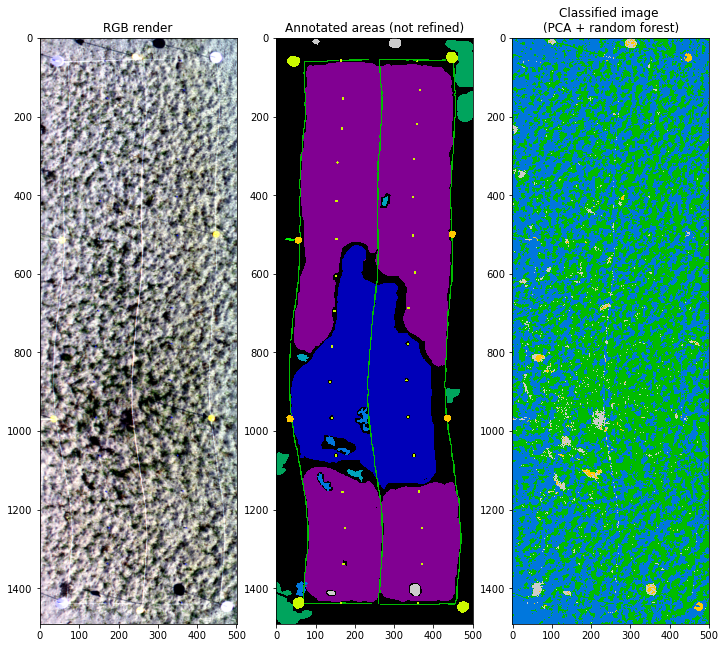

In [19]:
# Visualize result
fig,ax = plt.subplots(ncols=3,figsize=(12,12))
ax[0].imshow(image_render.percentile_stretch(im2[:,:,rgb_ind]))
ax[0].set_title('RGB render')

ax[1].imshow(annotation_mask2,interpolation='none',cmap='nipy_spectral')
ax[1].set_title('Annotated areas (not refined)')

y_im2[0,0] = 0
ax[2].imshow(y_im2,interpolation='none',cmap='nipy_spectral')
ax[2].set_title('Classified image \n(PCA + random forest)')

plt.show()

The image of annotated areas above does has not been refined to show probable seagrass areas. Color mapping also does not match the classified image. However, the classified image matches the visual impression of seagrass density quite well. Also, there are small patches of rockweed that are quite accurately picked out by the classification (and which are quite hard to visually distingusih from seagrass.